# Generative Adversarial Network Example

Build a generative adversarial network (GAN) to generate digit images from a noise distribution with TensorFlow.

- Author: Aymeric Damien
- Project: https://github.com/aymericdamien/TensorFlow-Examples/

In [1]:
from __future__ import division, print_function, absolute_import

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


# Classifier Model

In [3]:
# Training Parameters
learning_rate_cnn = 0.001
num_steps_cnn = 500
batch_size = 128
display_step = 10

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

# tf Graph input
X = tf.placeholder(tf.float32, [None, num_input])
Y = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)

In [4]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
    # Reshape to match picture format [Height x Width x Channel]
    # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [5]:
# Store layers weight & bias
weights_cnn = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, num_classes]))
}

biases_cnn = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

# Construct model
logits = conv_net(X, weights_cnn, biases_cnn, keep_prob)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
loss_sc = -tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_cnn)
train_op = optimizer.minimize(loss_op)

correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [9]:
# Clip the image based on percentile and rescale 
def clip_and_recenter(middle_percentile, img):
    percentile = 100-(100-middle_percentile)/2
    upper_bound = np.percentile(img, percentile, axis = 1)
    lower_bound = np.percentile(img, 100 - percentile, axis = 1)
    img = np.divide(np.subtract(img.T, lower_bound), (upper_bound-lower_bound)).T
    # Clip the image
    img[img > 1] = 1
    img[img < 0] = 0
    return img
def clip_and_recenter2(percentile, img):
    upper_bound = np.percentile(img, percentile, axis = 1)
    lower_bound = np.percentile(img, 0, axis = 1)
    img = np.divide(img.T, (upper_bound-lower_bound)).T
    # Clip the image
    img[img > 1] = 1
    img[img < 0] = 0
    return img

# Discriminator Model

In [10]:
# Training Parameters
learning_rate_discriminator = 0.001
batch_size_discriminator = 128

# Network Parameters
num_input_discriminator = 784 # MNIST data input (img shape: 28*28)
num_classes_discriminator = 1 # One score for each image
dropout_discriminator = 0.75 # Dropout, probability to keep units

In [11]:
# Create the neural network
def cnn_dis (x, dropout, batch_size, reuse):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('Discriminator', reuse=reuse):
        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[batch_size, 28, 28, 1])

        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 32 filters and a kernel size of 5
        conv2 = tf.layers.conv2d(conv1, 64, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=True)

        # Add second Fully connected layer
        fc2 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc2 = tf.layers.dropout(fc2, rate=dropout, training=True)
        
        # Output layer, class prediction
        out_l = tf.layers.dense(fc2, 1)

#         # Output layer, class prediction
#         out_l = tf.layers.dense(fc1, 1)        
        #Output layer after sigmoid
        out = tf.nn.sigmoid(out_l)  

    return out, out_l

In [12]:
from IPython import display
# Real image: discriminator(X) = 1;  Fake image: discriminator(X) = 0;
X_fake = tf.placeholder(tf.float32, [None, num_input_discriminator])
X_real = tf.placeholder(tf.float32, [None, num_input_discriminator])
dis_score_fake,dis_logist_fake = cnn_dis(X_fake, dropout_discriminator, batch_size_discriminator, reuse = False)
dis_score_real,dis_logist_real = cnn_dis(X_real, dropout_discriminator, batch_size_discriminator, reuse = True)

dis_img = tf.reduce_mean(dis_score_fake)
dis_grad = tf.gradients(dis_img, X_fake)

disc_real = -tf.reduce_mean(tf.log(dis_score_real))
disc_fake = -tf.reduce_mean(tf.log(1. - dis_score_fake))
disc_loss = disc_real + disc_fake

# Create Optimizer and training operations 
opt_real = tf.train.AdamOptimizer(learning_rate=learning_rate_discriminator)
train_dis = opt_real.minimize(disc_loss, global_step=tf.train.get_global_step())

### Target classifier output layer gradient to look at

In [13]:
zero = tf.slice(logits,begin=[0,0],size=[128,1])
#grad = tf.gradients(tf.reduce_mean(zero), X)
grad = tf.gradients(loss_sc, X)

# Training

In [14]:
# Training the classifier
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
#with tf.Session() as sess:
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

In [15]:
# save_path = saver.save(sess, "./models/class_fc2_discriminator.ckpt")
saver.restore(sess, "./models/class_fc2_discriminator.ckpt")
# #weights_now = sess.run(weights_cnn['wc1'])
# #print(weights_now)
# def resetit():
#     sess.run(tf.global_variables_initializer())
#     saver.restore(sess, "./models/class_and_fc2_discriminator_.ckpt")
    

INFO:tensorflow:Restoring parameters from ./models/class_fc2_discriminator.ckpt


In [16]:
n = 10
canvas = np.empty((28 * n, 28 * n))

In [17]:
my_Y = np.zeros((128,10))
for i in range(128):
    my_Y[i][i%10]= 1
#print(my_Y)
from ipywidgets import widgets
from ipywidgets import IntSlider
from ipywidgets import FloatSlider
from ipywidgets import Checkbox
style = {'description_width': 'initial'}

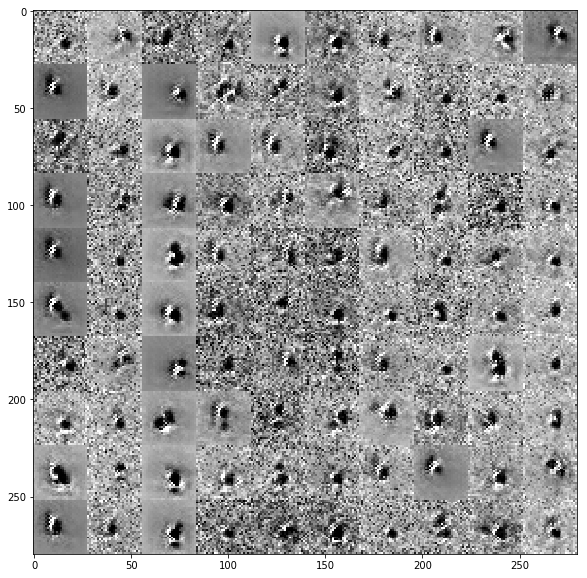

iter=8
Gradient Noise Level = 0.0
Learning Rate of Classifier Gradient = 0.01
Learning Rate of Discriminator Gradient = 0.098


FloatSlider(value=0.0, description=u'Gradient Noise Level', max=0.05, step=0.001, style=SliderStyle(description_width=u'initial'))

FloatSlider(value=0.005, description=u'L2 regularization', max=0.01, step=0.0001, style=SliderStyle(description_width=u'initial'))

FloatSlider(value=0.01, description=u'LR of Cls Grad', max=0.5, step=0.001, style=SliderStyle(description_width=u'initial'))

FloatSlider(value=0.098, description=u'LR of Dis Grad', max=0.5, step=0.001, style=SliderStyle(description_width=u'initial'))

IntSlider(value=10, description=u'Iter count', min=1, style=SliderStyle(description_width=u'initial'))

Checkbox(value=False, description=u'Stop Training Discriminator')

Discriminator Score=0.00492144 -6.37006 -6.28459 After 99 steps


In [18]:
from math import sqrt
import threading
import time
grad_noise_slider = FloatSlider(description='Gradient Noise Level', style=style, min=0,max=0.05,step=0.001,value=0.00)
l2_reg_slider = FloatSlider(description = 'L2 regularization', style=style,min=0,max=0.01,step=0.0001,value=0.005)
lr_cls_slider = FloatSlider(description = 'LR of Cls Grad', style=style,min=0,max=0.5,step=0.001,value=0.01)
lr_dis_slider = FloatSlider(description = 'LR of Dis Grad',min=0,max=0.5,step=0.001,style=style,value=0.01)
iter_slider = IntSlider(description = 'Iter count',min=1,max=100,step=1,style=style,value=10)
reset_check = Checkbox(description = 'Reset now', value=False)
stop_training_dis_check = Checkbox(description = 'Stop Training Discriminator', value=False)
def work():
    accumulateDiscriminator = np.zeros((batch_size_discriminator, num_input_discriminator))
    accumulateClassifier = np.zeros((batch_size_discriminator, num_input_discriminator))
    # Train Discriminator
    noise_img = np.random.rand(batch_size_discriminator, num_input_discriminator)
    img = noise_img
    for j1 in range(5):
        noise_img = np.random.rand(batch_size_discriminator, num_input_discriminator)
        img = noise_img
        accumulateDiscriminator[:] = 0
        accumulateClassifier[:] = 0
        for k in range(iter_slider.value):
            st, end = 0, 0
            learning_rate_class = lr_cls_slider.value
            learning_rate_dis = lr_dis_slider.value      
            stop_training_dis = stop_training_dis_check.value
            reg = l2_reg_slider.value
            for inter_loop in range(100):
                # What's the input batch_y should be?
                g, ll, p, dis_score, dl_, g_from_dis = sess.run(
                    [grad, loss_op, prediction, dis_img, dis_logist_fake, dis_grad], \
                    feed_dict={X: img, Y: my_Y, X_fake: img, keep_prob: 1.0})
                # L2 regularization
                g = g - reg*img
                # Accumulate and Normalize the gradient
                accumulateClassifier = 0.1 * g[0] ** 2 + 0.9 * accumulateClassifier
                accumulateDiscriminator = 0.1 * g_from_dis[0] ** 2 + 0.9 * accumulateDiscriminator
                normalized_class_grad = g[0] / np.sqrt(accumulateClassifier + 1e-8)
                normalized_dis_grad = g_from_dis[0] / np.sqrt(accumulateDiscriminator + 1e-8)

                # Add the gradient from discriminator and classifier
                noise = np.random.normal(batch_size_discriminator, num_input_discriminator)
                img += (learning_rate_class) * (normalized_class_grad + float(grad_noise_slider.value)*noise)
                img += (learning_rate_dis) * (normalized_dis_grad)

                # Clipping the image to range 0-1
#                 img[img > 1] = 1
#                 img[img < 0] = 0
                 # Clipping and rescale the image
                img = clip_and_recenter(99, img)
                if (inter_loop == 0):
                    st = dl_.mean()
                if (dis_score > 0.9):
                    break
            for i in range(n):
                for j in range(n):
                    # Draw the generated digits
                    canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = img[(i - 1) * n + j].reshape([28, 28])
            plt.figure(figsize=(n, n))
            plt.imshow(canvas, origin="upper", cmap="gray")
            plt.show()
            print('iter=' + str(k))
            print("Gradient Noise Level = "+str(float(grad_noise_slider.value)))
            print("Learning Rate of Classifier Gradient = "+str(lr_cls_slider.value))
            print("Learning Rate of Discriminator Gradient = "+str(lr_dis_slider.value))
            display.display(grad_noise_slider)
            display.display(l2_reg_slider)
            display.display(lr_cls_slider)
            display.display(lr_dis_slider)
            display.display(iter_slider)
            display.display(stop_training_dis_check)
            #display.display(reset_check)
            # print('Dis Gradient range  =' + str(np.min(normalized_dis_grad[0])) + " " + str(np.max(normalized_dis_grad[0])))
            # print('Class Gradient range  =' + str(np.min(normalized_class_grad)) + " " + str(np.max(normalized_class_grad)))
            print('Discriminator Score=' + str(dis_score) + " "+ str(st)+" "+str(dl_.mean())+ " After " + str(inter_loop)+ " steps")

            batch_x, _ = mnist.train.next_batch(batch_size_discriminator)
            if (not stop_training_dis) and (k < 5):
                print("Still training discriminator")
                sess.run([train_dis], feed_dict={X_fake: img, X_real: batch_x})
            display.clear_output(wait=True)
            time.sleep(0.2)
thread = threading.Thread(target=work)
thread.start()